# Training and Testing an MDRNN on Synthetic Data

This script trains and tests a mixture density recurrent neural network (MDRNN) on synthetic performances.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import time
import sketch_mdn

## Generating Fake data:

The idea is to generate some data that "could" have been human, but has a regular pattern. The time axis is sampled from a normal distribution with the same mean and S.D. as the human corpus. The value axis is generated by applying regular signal functions (e.g., sine, square, triangle) to this time axis.


In [ ]:
# Generate fake Sine movement

time_mean = 0.044860
time_std = 0.183995
time_min = 0.000454
time_max = 8.463944
NSAMPLE = 15000

t_diffs = np.random.normal(loc=time_mean, scale=time_std, size=NSAMPLE)

sine_df = pd.DataFrame({'dt' : t_diffs})
sine_df.dt = sine_df.dt.abs()
sine_df['seconds'] = sine_df.dt.cumsum()
sine_df['value'] = (np.sin(sine_df.seconds) * 0.5) + 0.5
print(sine_df.describe())

ax = sine_df[:1000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.get_figure().savefig('sine_data_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('sine_data_output.png', dpi=300, bbox_inches="tight")

corpus_df = pd.DataFrame({'t': sine_df.dt, 'x': sine_df.value})
sine_corpus = np.array(corpus_df)

In [ ]:
# Generate fake Squarey Movement

time_mean = 0.044860
time_std = 0.183995
time_min = 0.000454
time_max = 8.463944
NSAMPLE = 15000

t_diffs = np.random.normal(loc=time_mean, scale=time_std, size=NSAMPLE)

square_df = pd.DataFrame({'dt' : t_diffs})
square_df.dt = square_df.dt.abs()
square_df['seconds'] = square_df.dt.cumsum()
square_df['value'] = (scipy.signal.square(square_df.seconds) * 0.5) + 0.5
print(square_df.describe())

ax = square_df[:1000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.get_figure().savefig('square_data_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('square_data_output.png', dpi=300, bbox_inches="tight")

corpus_df = pd.DataFrame({'t': square_df.dt, 'x': square_df.value})
square_corpus = np.array(corpus_df)

In [ ]:
# Generate fake triangle-y Movement

time_mean = 0.044860
time_std = 0.183995
time_min = 0.000454
time_max = 8.463944
NSAMPLE = 15000

t_diffs = np.random.normal(loc=time_mean, scale=time_std, size=NSAMPLE)

tri_df = pd.DataFrame({'dt' : t_diffs})
tri_df.dt = tri_df.dt.abs()
tri_df['seconds'] = tri_df.dt.cumsum()
tri_df['value'] = (scipy.signal.sawtooth(tri_df.seconds, width=0.5) * 0.5) + 0.5
print(tri_df.describe())

ax = tri_df[:1000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.get_figure().savefig('tri_data_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('tri_data_output.png', dpi=300, bbox_inches="tight")

corpus_df = pd.DataFrame({'t': tri_df.dt, 'x': tri_df.value})
tri_corpus = np.array(corpus_df)

# Train networks with the Synthetic data

Training an MDN with these synthetic data sets.

### Here are the corpora

- square_corpus
- tri_corpus
- sine_corpus

In [ ]:
# Hyperparameters
units = 128
mixes = 8
layers = 1
batch_s = 100
n_steps = 120
epochs = 10

# Train
net = sketch_mdn.MixtureRNN(mode = sketch_mdn.NET_MODE_TRAIN, 
                            n_hidden_units=units, 
                            n_mixtures=mixes, 
                            batch_size=batch_s, 
                            sequence_length=n_steps, 
                            layers=layers)
loader = sketch_mdn.SequenceDataLoader(num_steps=(n_steps + 1), batch_size=batch_s, corpus=tri_corpus)
losses = net.train(loader, epochs, saving=True)
## Plot the losses.
plt.plot(losses)
plt.show()

## Investigate some generated data:



INFO:tensorflow:Loading Running Operations
INFO:tensorflow:done initialising: mixture-rnn-1layers-128units vars: 73264
Test Input: [ 0.01190309  0.56857053]
INFO:tensorflow:Restoring parameters from ./mixture-rnn-1layers-128units
Test Output:
                dt        value      seconds
count  2001.000000  2001.000000  2001.000000
mean      0.143515     0.439978   143.456410
std       0.111488     0.224395    81.402229
min       0.000454     0.000000     0.011903
25%       0.062393     0.264420    73.945237
50%       0.128846     0.435049   141.941292
75%       0.201294     0.608832   214.118605
max       1.074888     1.000000   287.172697


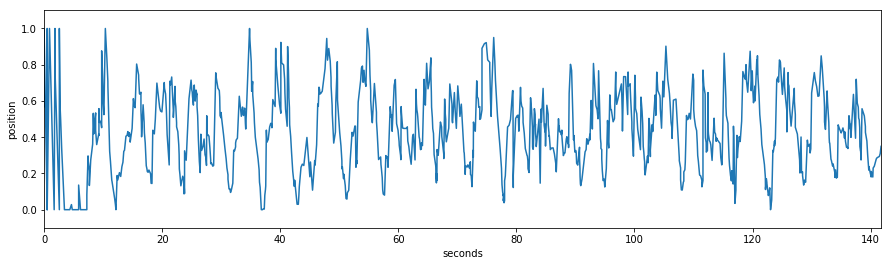

In [2]:
# Hyperparameters
units = 128
mixes = 8
layers = 1
batch_s = 1
n_steps = 1

# Instantiate Running Network
net = sketch_mdn.MixtureRNN(mode = sketch_mdn.NET_MODE_RUN, 
                            n_hidden_units=units, 
                            n_mixtures=mixes, 
                            batch_size=batch_s, 
                            sequence_length=n_steps, 
                            layers=layers)

first_touch = np.array([(0.01 + (np.random.rand()-0.5)*0.005), np.random.rand()])
print("Test Input:",first_touch)

with tf.Session() as sess:
    perf = net.generate_performance(first_touch,2000,sess)
print("Test Output:")
perf_df = pd.DataFrame({'dt':perf.T[0], 'value':perf.T[1]})
perf_df['seconds'] = perf_df.dt.cumsum()

print(perf_df.describe())

ax = perf_df[:1000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.set_ylim([-0.1,1.1])
ax.get_figure().savefig('synth_net_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('synth_net_output.png', dpi=300, bbox_inches="tight")

# #plt.show(perf_df.plot('time','x',kind='scatter'))
# plt.plot(perf_df.time, perf_df.x, '.r-')
# plt.show()
# 

# ## Investigate Output
# window = 100
# for n in [1000,2000,3000,4000,5000,6000]:
#     print("Window:", str(n),'to',str(n+window))
#     plt.plot(perf_df[n:n+window].time, perf_df[n:n+window].x, '.r-')
#     plt.show()

# input_touch = first_touch.reshape([1,1,net.n_input_units]) ## Give input correct shape for one-at-a-time evaluation.
# if net.state is not None:
#     feed = {net.x: input_touch, net.init_state: net.state}
# else:
#     feed = {net.x: input_touch}
# pis, locs_1, locs_2, scales_1, scales_2, corr, net.state = sess.run([net.pis, net.locs_1, net.locs_2, net.scales_1, net.scales_2,  net.corr, net.final_state], feed_dict=feed)
# #x_1, x_2 = sketch_mixture.sample_mixture_model(pis, locs_1, locs_2, scales_1, scales_2, corr, temp=1.0, greedy=False)




In [ ]:

ax = perf_df[:1000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.set_ylim([-0.1,1.1])
ax.get_figure().savefig('synth_net_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('synth_net_output.png', dpi=300, bbox_inches="tight")

